## Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classifiaction models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too). 
<br><br>
The set up and approach will not be too dissimilar to the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysing tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exercise is mainly trying to focus.  
<br>
Feel free to adapt this exercise to play with other datasets readily availabe in the Databricks enviornment (they are listed in a cell below). 
##### Getting Started
To get started you will need to create and attach a databricks spark cluster to this notebook. This notebook was developed on a cluster created with: 
- Databricks Runtime Version 4.0 (includes Apache Spark 2.3.0, Scala 2.11)
- Python Version 3

##### Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)



#### Get Data



Lets take a look at the '**adult**' dataset on the filesystem. This is the typical US Census data you often see online in tutorials. [Here](https://archive.ics.uci.edu/ml/datasets/adult) is the same data in the UCI repository.

_As an aside: [here](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census) this same dataset is used as a quickstart example for Google CLoud ML & Tensorflow Estimator API (in case youd be interested in playing with tensorflow on the same dataset as here)._ 

In [164]:
!ls data/

Index           adult.data      adult.names     adult.test      old.adult.names


#### Spark DataFrames
Below we will create our DataFrame from the csv file data and do some analysis with Spark SQL but using the DataFrames API.

The following steps is a twist from the Databricks version where the data from the csv file is loaded straight into Spark SQL using sql magic.

In the non Databricks version, we need to:

- Create a spark session, 
- Load the data file into spark, then 
- Register the Spark dataframe as the SQL table source.

Note: 
  - Intall pyspark (Standalone: No need to install Apache Spark)

1. Create a Spark Session

In [165]:
from pyspark.sql import SparkSession
import logging
logging.basicConfig(level=logging.ERROR)

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("SparkSQLExample") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to suppress lengthy warnings in the output.
log4j = spark.sparkContext._jvm.org.apache.log4j
log = log4j.LogManager.getLogger("org.apache.spark")
log.setLevel(log4j.Level.ERROR)

2. Load the adult.data csv file into Spark

In [166]:
# Path to your CSV file
csv_file_path = "data/adult.data"

# Load CSV into DataFrame
adult_df = spark.read.csv(csv_file_path, header=False, inferSchema=True)

# Insert column names
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 
           'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
           'hours_per_week', 'native_country', 'income']
adult_df = adult_df.toDF(*columns)

3. Register the dataframe as SQL data source

You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason. 

In [167]:
# Register the dataframe as a SQL Table
adult_df.createOrReplaceTempView("adult")

In [168]:
# You can also register a df from spark
adult_df = spark.table("adult")
cols = adult_df.columns # this will be used much later in the notebook, ignore for now

In [169]:
# look at df schema
adult_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [170]:
# look at the df
adult_df.show(5)

+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad|       

#### Spark SQL

In [171]:
# look at the data
# this will look prettier in Databricks if you use display() instead
sql_result = spark.sql("SELECT * FROM adult LIMIT 5")

sql_result.show()

+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad|       

If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes. 

In [172]:
# Lets get some summary marital status rates by occupation
sql_result = spark.sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  """)

sql_result.show()

+------------------+----+------------+----------+------------+--------------+-------------+
|        occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+------------------+----+------------+----------+------------+--------------+-------------+
|    Prof-specialty|4140|        0.53|      0.02|        0.13|          0.02|          0.3|
|      Craft-repair|4099|        0.64|      0.01|        0.11|          0.03|         0.21|
|   Exec-managerial|4066|        0.61|      0.02|        0.15|          0.02|          0.2|
|      Adm-clerical|3770|        0.28|      0.04|        0.22|          0.04|         0.42|
|             Sales|3650|        0.47|      0.03|        0.12|          0.03|         0.36|
|     Other-service|3295|        0.24|      0.05|        0.15|          0.06|          0.5|
| Machine-op-inspct|2002|        0.51|      0.03|        0.14|          0.04|         0.29|
|                 ?|1843|        0.36|      0.08|         0.1|          0.04|   

Load our query result for the married rate by occupation into spark. 

In [173]:
sql_result.createOrReplaceTempView("top_married_rate_by_occupation")

You can now query the newly created table:

In [174]:

spark.sql("SELECT * FROM top_married_rate_by_occupation").show(5)

+----------------+----+------------+----------+------------+--------------+-------------+
|      occupation|   n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+----------------+----+------------+----------+------------+--------------+-------------+
|  Prof-specialty|4140|        0.53|      0.02|        0.13|          0.02|          0.3|
|    Craft-repair|4099|        0.64|      0.01|        0.11|          0.03|         0.21|
| Exec-managerial|4066|        0.61|      0.02|        0.15|          0.02|          0.2|
|    Adm-clerical|3770|        0.28|      0.04|        0.22|          0.04|         0.42|
|           Sales|3650|        0.47|      0.03|        0.12|          0.03|         0.36|
+----------------+----+------------+----------+------------+--------------+-------------+
only showing top 5 rows



#### <span style="color:darkblue">Question 1</span>

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [175]:
### Question 1.1 Answer ###

sql_result = spark.sql(
  """
  SELECT 
  education,
  SUM(1) as n,
  ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM adult
  GROUP BY 1
  ORDER BY bachelor_rate DESC
  """
) 
sql_result.show(5)

+-------------+----+-------------+
|    education|   n|bachelor_rate|
+-------------+----+-------------+
|         12th| 433|         0.54|
|         11th|1175|          0.5|
|    Preschool|  51|         0.43|
| Some-college|7291|          0.4|
|         10th| 933|         0.39|
+-------------+----+-------------+
only showing top 5 rows



Below we will do a similar calculation to what we did above but using the DataFrames API

In [176]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
result_df = adult_df.select(
  adult_df['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
result_df = result_df.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
result_df = result_df.orderBy(desc('divorced_rate'))
# show results
result_df.show(5)

+----------------+-------------+
|      occupation|divorced_rate|
+----------------+-------------+
|    Adm-clerical|         0.22|
| Priv-house-serv|         0.19|
| Exec-managerial|         0.15|
|    Tech-support|         0.15|
|   Other-service|         0.15|
+----------------+-------------+
only showing top 5 rows



As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.  

#### <span style="color:darkblue">Question 2</span>
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [177]:
from pyspark.sql import functions as F
### Question 2.1 Answer ###

result_df = adult_df.groupBy('education').agg(
  F.count(F.lit(1).alias('n')),
  F.round(F.avg(F.when(F.trim(adult_df['marital_status']) == 'Never-married', 1).otherwise(0)), 2).alias('bachelor_rate')
).orderBy(F.col('bachelor_rate').desc())

result_df.show(1)

+---------+-------------+-------------+
|education|count(1 AS n)|bachelor_rate|
+---------+-------------+-------------+
|     12th|          433|         0.54|
+---------+-------------+-------------+
only showing top 1 row



#### Explore & Visualize Data
It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df. 

In [178]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

         occupation  plus_50k
0   Exec-managerial  0.484014
1    Prof-specialty  0.449034
2   Protective-serv  0.325116
3      Tech-support  0.304957
4             Sales  0.269315


In [179]:
print(df_pandas.describe())

        plus_50k
count  15.000000
mean    0.197354
std     0.143994
min     0.006711
25%     0.107373
50%     0.134483
75%     0.287136
max     0.484014


In [180]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   occupation  15 non-null     object 
 1   plus_50k    15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 372.0+ bytes
None


Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want). 

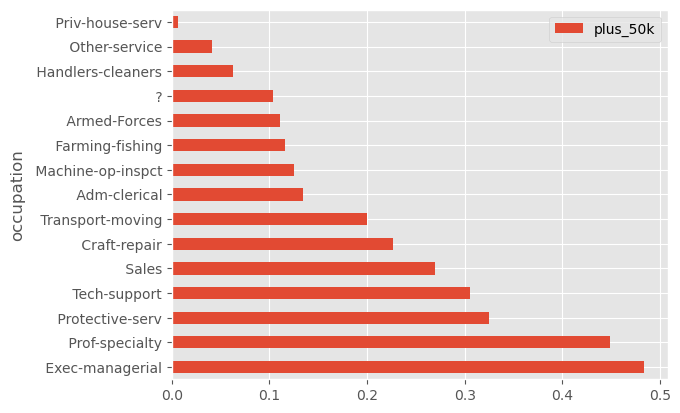

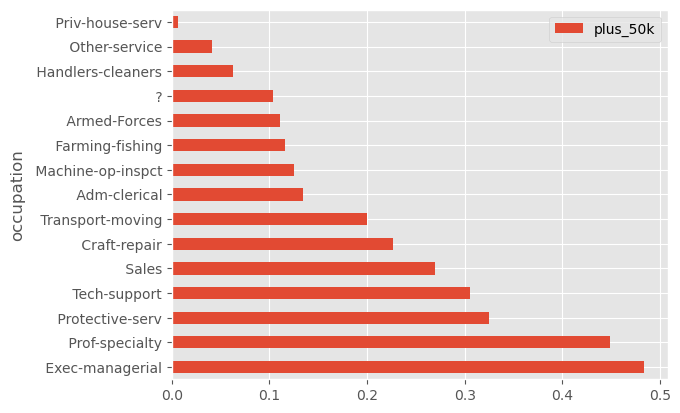

In [181]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function - 
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.  

In [182]:
# describe df
adult_df.select(adult_df['age'],adult_df['education_num']).describe().show()

+-------+------------------+-----------------+
|summary|               age|    education_num|
+-------+------------------+-----------------+
|  count|             32561|            32561|
|   mean| 38.58164675532078| 10.0806793403151|
| stddev|13.640432553581356|2.572720332067397|
|    min|                17|              1.0|
|    max|                90|             16.0|
+-------+------------------+-----------------+




### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

In [183]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [184]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [185]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [186]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(adult_df)
dataset = pipelineModel.transform(adult_df)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)

dataset.show()

+-----+--------------------+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
|label|            features|age|        workclass|  fnlwgt|    education|education_num|      marital_status|        occupation|  relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-----+--------------------+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
|  0.0|(100,[4,10,24,32,...| 39|        State-gov| 77516.0|    Bachelors|         13.0|       Never-married|      Adm-clerical| Not-in-family|              White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|  0.0|(100,[1,10,23,31,...| 50| Self-emp-not-inc| 83311.0|    B

In [187]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22832
9729


In [188]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.23988262088297127



#### Logistic Regression - Train

In [189]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.33643403980086317


#### GBM - Train

#### <span style="color:darkblue">Question 3</span>
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [190]:
from pyspark.ml.classification import GBTClassifier

### Question 3.1 Answer ###

# Create GBTClassifier model
gb = GBTClassifier(labelCol='label', featuresCol='features')

# Train model with Training Data
gbModel = gb.fit(trainingData)


#### Logistic Regression - Predict

In [191]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
result_df = lrPredictions.select("label", "prediction", "probability")

result_df.show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.16646708724833...|
|  0.0|       1.0|[0.70012031106347...|
|  0.0|       1.0|[0.53453682932966...|
|  0.0|       1.0|[0.67559303222185...|
|  0.0|       1.0|[0.62237992652147...|
|  0.0|       1.0|[0.61047384917734...|
|  0.0|       1.0|[0.60270631574160...|
|  0.0|       1.0|[0.60470503143804...|
|  0.0|       1.0|[0.74230866284293...|
|  0.0|       0.0|[0.98954486365582...|
|  0.0|       1.0|[0.35443820573118...|
|  0.0|       1.0|[0.52012311192879...|
|  0.0|       1.0|[0.57001207297900...|
|  0.0|       1.0|[0.72429051822755...|
|  0.0|       1.0|[0.65121742871644...|
|  0.0|       1.0|[0.66775456351897...|
|  0.0|       1.0|[0.52371842805163...|
|  0.0|       1.0|[0.36773833412271...|
|  0.0|       1.0|[0.48770095744495...|
|  0.0|       1.0|[0.32713602186495...|
+-----+----------+--------------------+
only showing top 20 rows




### GBM - Predict

#### <span style="color:darkblue">Question 4</span>
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [192]:
### Question 4.1 Answer ###

# make predictions on test data
gbPredictions = gbModel.transform(testData)

result_df = gbPredictions.select('label', 'prediction', 'probability')

result_df.show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.22871586565307...|
|  0.0|       0.0|[0.76002155634970...|
|  0.0|       0.0|[0.68621469497458...|
|  0.0|       0.0|[0.64714950780972...|
|  0.0|       0.0|[0.60037720427173...|
|  0.0|       0.0|[0.61161497295995...|
|  0.0|       0.0|[0.61161497295995...|
|  0.0|       0.0|[0.78272593825106...|
|  0.0|       0.0|[0.73469864660007...|
|  0.0|       0.0|[0.87734443156483...|
|  0.0|       1.0|[0.42248754254994...|
|  0.0|       0.0|[0.59860712488349...|
|  0.0|       0.0|[0.61282761716197...|
|  0.0|       0.0|[0.62934732659411...|
|  0.0|       0.0|[0.65059226873479...|
|  0.0|       0.0|[0.85149647822220...|
|  0.0|       0.0|[0.54561329060604...|
|  0.0|       1.0|[0.23325342925184...|
|  0.0|       0.0|[0.67806977402571...|
|  0.0|       1.0|[0.23325342925184...|
+-----+----------+--------------------+
only showing top 20 rows



#### <span style="color:darkblue">Question 5</span>
1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [193]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {:.3f}".format(auc))
  print("aupr = {:.3f}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {:.3f}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {:.3f}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {:.3f}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###

  labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

  for label in labels:
    if label == 0:
      continue
    # F1
    print("F1 = {:.3f}".format(multi_metrics.fMeasure(label)))
    # Precision
    print("Precision = {:.3f}".format(multi_metrics.precision(label)))
    # Recall
    print("Recall = {:.3f}".format(multi_metrics.recall(label)))
    # FPR
    print("FPR = {:.3f}".format(multi_metrics.falsePositiveRate(label)))
    # TPR
    print("TPR = {:.3f}".format(multi_metrics.truePositiveRate(label)))
   



#### Logistic Regression - Evaluate

In [194]:
print_performance_metrics(lrPredictions)

auc = 0.901
aupr = 0.760


/Users/judesantos/miniconda3/envs/mlenv/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR = 0.547
Area under ROC = 0.818
Accuracy = 0.810
DenseMatrix([[5903., 1462.],
             [ 391., 1973.]])
F1 = 0.680
Precision = 0.574
Recall = 0.835
FPR = 0.199
TPR = 0.835


#### GBM - Evaluate

In [195]:
print_performance_metrics(gbPredictions)

auc = 0.908
aupr = 0.771
Area under PR = 0.643
Area under ROC = 0.752
Accuracy = 0.850
DenseMatrix([[6934.,  431.],
             [1033., 1331.]])
F1 = 0.645
Precision = 0.755
Recall = 0.563
FPR = 0.059
TPR = 0.563



## Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each. 

In [196]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [197]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 


#### Logisitic Regression - Param Grid

In [198]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

#### GBM - Param Grid

#### <span style="color:darkblue">Question 6</span>
1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [199]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation
gbParamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [1, 10, 30])
             .addGrid(gb.stepSize, [0.0001, 0.01, 0.1])
             .addGrid(gb.maxIter, [2, 5])
             .build()) 


#### Logistic Regression - Perform Cross Validation

In [200]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [201]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.5
5


#### GBM - Perform Cross Validation

#### <span style="color:darkblue">Question 7</span>
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [202]:
### Question 7.1 Answer ###

#spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2) 

# Run cross validations
gbCvModel = gbCv.fit(trainingData)

In [203]:
### Question 7.2 Answer ###

# look at best params from the CV
print(gbCvModel.bestModel._java_obj.getMaxDepth())
print(gbCvModel.bestModel._java_obj.getStepSize())
print(gbCvModel.bestModel._java_obj.getMaxIter())

10
0.1
5


#### Logistic Regression - CV Model Predict

In [204]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

lrCvPredictions.show()

+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(100,[0,8,23,29,4...| 36|  Private|370767.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White|   Male|         0.0|      2377.0|          60.0| United-States| <=50K|[-0.7971643691213...|[0.310632

#### GBM - CV Model Predict

In [205]:
gbCvPredictions = gbCvModel.transform(testData)

gbCvPredictions.show()

+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|label|            features|age|workclass|  fnlwgt|education|education_num|     marital_status|     occupation|relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---------+--------+---------+-------------+-------------------+---------------+------------+------+-------+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
|  0.0|(100,[0,8,23,29,4...| 36|  Private|370767.0|  HS-grad|          9.0| Married-civ-spouse| Prof-specialty|     Husband| White|   Male|         0.0|      2377.0|          60.0| United-States| <=50K|[-0.7717963475769...|[0.176013

#### Logistic Regression - CV Model Evaluate

In [206]:
print_performance_metrics(lrCvPredictions)

auc = 0.897
aupr = 0.743
Area under PR = 0.526
Area under ROC = 0.817
Accuracy = 0.793
DenseMatrix([[5674., 1691.],
             [ 322., 2042.]])
F1 = 0.670
Precision = 0.547
Recall = 0.864
FPR = 0.230
TPR = 0.864


#### GBM - CV Model Evaluate

In [207]:
print_performance_metrics(gbCvPredictions)

auc = 0.894
aupr = 0.733
Area under PR = 0.631
Area under ROC = 0.762
Accuracy = 0.848
DenseMatrix([[6844.,  521.],
             [ 959., 1405.]])
F1 = 0.655
Precision = 0.729
Recall = 0.594
FPR = 0.071
TPR = 0.594


#### Logistic Regression - Model Explore

In [208]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -6.366757982652425


In [209]:
from pyspark.sql.types import StructType, StructField, StringType

lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple

schema = StructType([
  StructField('Feature Weight', StringType(), True)
])

lrWeightsDF = spark.createDataFrame(lrWeights, schema)
lrWeightsDF.createOrReplaceTempView('feature_weight')

lrWeightsDF.show()

+--------------------+
|      Feature Weight|
+--------------------+
| 0.05515969065133605|
|  -0.091272082177089|
|                 0.0|
|-0.08820976897759536|
|                 0.0|
| 0.25844291981679046|
|  0.3991123728299104|
|                 0.0|
|-0.10445953904829859|
|                 0.0|
|  0.3848817827497777|
| 0.48223884630742536|
|                 0.0|
| -0.2103308377614565|
|                 0.0|
|-0.05217591013137434|
| -0.2536419833670164|
|  0.5530195117061469|
|-0.03963287251291965|
|                 0.0|
+--------------------+
only showing top 20 rows



### Feature Importance

#### <span style="color:darkblue">Question 8</span>
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [210]:
### Question 8.1 Answer ###

# from: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

# fill in here
from itertools import chain

transformed = lrCvModel.bestModel.transform(trainingData)
attrs = sorted((attr["idx"], attr["name"]) for attr in (chain(*transformed.schema["features"].metadata["ml_attr"]["attrs"].values())))

In [211]:
gbCvFeatureImportance = pd.DataFrame([(name, gbCvModel.bestModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

gbCvFeatureImportance.sort_values(by=['feature_importance'],ascending =False).head(9)

,feature_name,feature_importance
23,marital_statusclassVec_ Married-civ-spouse,0.242153
96,education_num,0.107597
94,age,0.097937
97,capital_gain,0.093710
95,fnlwgt,0.074538
99,hours_per_week,0.067541
98,capital_loss,0.036817
31,occupationclassVec_ Exec-managerial,0.016547
1,workclassclassVec_ Self-emp-not-inc,0.012847


#### <span style="color:darkblue">Question 9</span>
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [212]:
### Question 9.1 Answer ###

from pyspark.ml.classification import RandomForestClassifier 

rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=10)

rfModel = rf.fit(trainingData)

rfFeatureImportance = rfModel.featureImportances

transformed = rfModel.transform(trainingData)
attrs = sorted((attr["idx"], attr["name"]) for attr in (chain(*transformed.schema["features"].metadata["ml_attr"]["attrs"].values())))
rfFeatureImportance = pd.DataFrame([(name, rfModel.featureImportances[idx]) for idx, name in attrs], columns=['feature_name','feature_importance'])

rfFeatureImportance.sort_values(by=['feature_importance'],ascending=False).head(9)


,feature_name,feature_importance
43,relationshipclassVec_ Husband,0.305620
97,capital_gain,0.161548
96,education_num,0.076412
45,relationshipclassVec_ Own-child,0.069789
52,sexclassVec_ Male,0.057341
29,occupationclassVec_ Prof-specialty,0.051258
98,capital_loss,0.049725
94,age,0.036230
44,relationshipclassVec_ Not-in-family,0.034008
